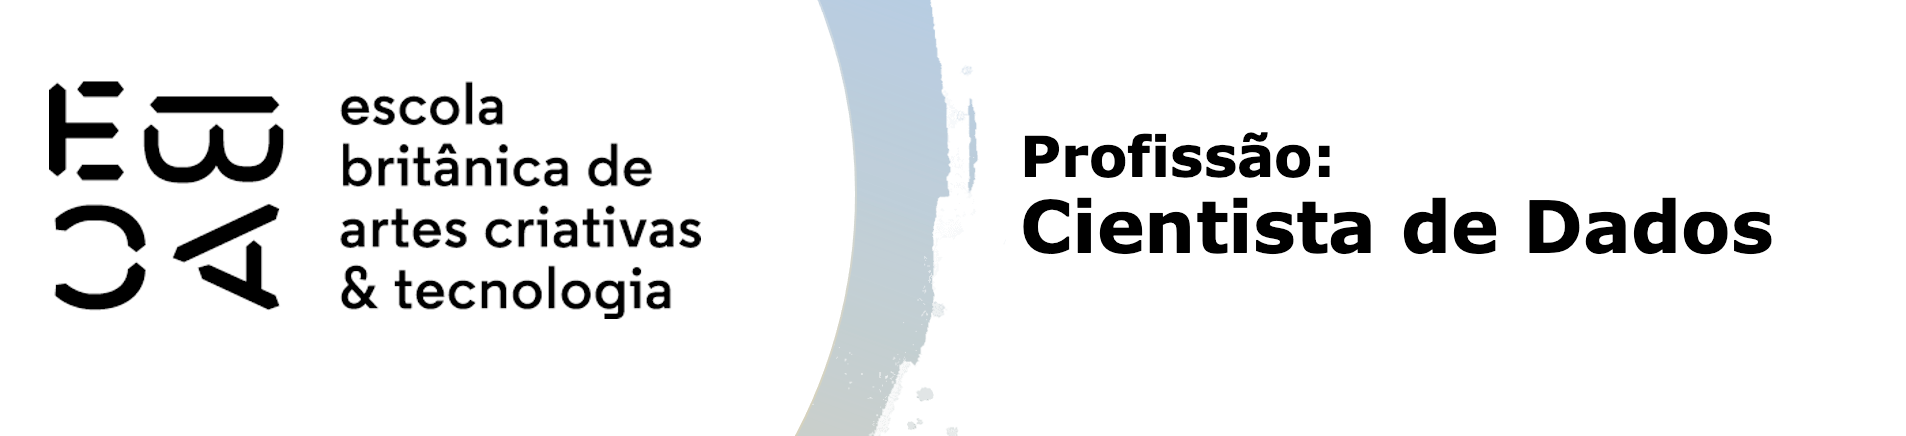

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [68]:
df = pd.read_csv('data/online_shoppers_intention.csv')

In [69]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [70]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

In [71]:
df_group = df.iloc[:,:6].copy()
df_group.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,0,0.0,0,0.0,1,0.000000
1,0,0.0,0,0.0,2,64.000000
2,0,0.0,0,0.0,1,0.000000
3,0,0.0,0,0.0,2,2.666667
4,0,0.0,0,0.0,10,627.500000


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis

In [72]:
df_group.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.0000,1.000000,4.000000,27.00000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.0000,7.500000,93.256250,3398.75000
Informational,12330.0,0.503569,1.270156,0.0,0.0000,0.000000,0.000000,24.00000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.0000,0.000000,0.000000,2549.37500
ProductRelated,12330.0,31.731468,44.475503,0.0,7.0000,18.000000,38.000000,705.00000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.1375,598.936905,1464.157214,63973.52223


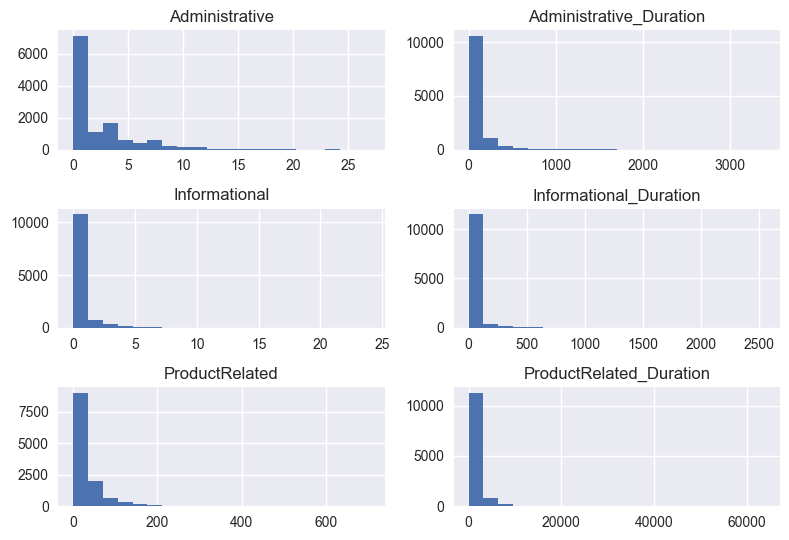

In [73]:
df_group.hist(bins=20)
plt.tight_layout()

- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [74]:
df_group.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

In [75]:
df_group_pad = pd.DataFrame(Normalizer().fit_transform(df_group), columns = df_group.columns)

In [76]:
df_group_pad.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,0.005038,0.031163,0.0,0.000000,0.000551,0.003781,1.000000
Administrative_Duration,12330.0,0.101124,0.196414,0.0,0.000000,0.006248,0.099780,0.999984
Informational,12330.0,0.001040,0.019877,0.0,0.000000,0.000000,0.000000,1.000000
Informational_Duration,12330.0,0.025292,0.098827,0.0,0.000000,0.000000,0.000000,0.999634
ProductRelated,12330.0,0.095323,0.225876,0.0,0.021124,0.032799,0.052652,1.000000
ProductRelated_Duration,12330.0,0.901444,0.257324,0.0,0.977277,0.997499,0.999413,1.000000


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [77]:
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(df_group_pad.iloc[:,:6])
    SQD.append(km.inertia_)
    
    nomes_grupos = ['G' + str(g) for g in range(k)]
    df_group_pad['k_'+str(k)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos).astype('category')
    

  0%|          | 0/14 [00:00<?, ?it/s]

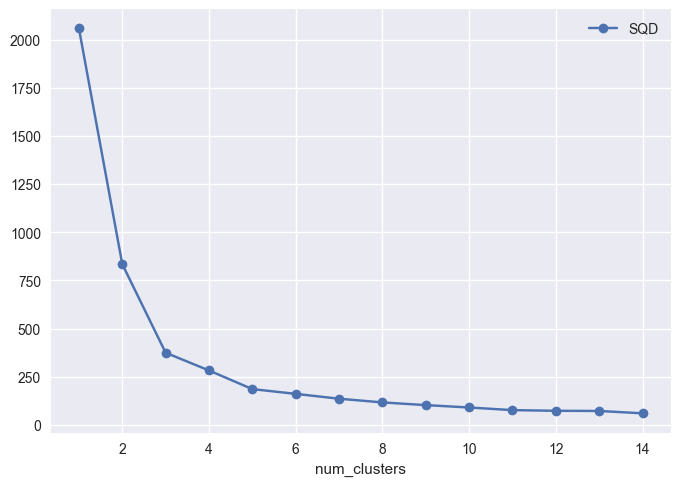

In [78]:
df_aux = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_aux.plot(x = 'num_clusters', y = 'SQD', marker='o');

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [98]:
def graph_cluster(df_group_pad, n_clusters = 2):

    df_aux = pd.concat([df_group_pad.iloc[:,:6], df_group_pad['k_'+str(n_clusters)]], axis=1)


    df_heat = df_aux.groupby('k_'+str(n_clusters)).mean()
    sns.heatmap(df_heat, annot=True)


    n_df = df_aux.groupby('k_'+str(n_clusters)).count()\
                                               .iloc[:,0]\
                                               .rename('N')\
                                               .to_frame()\
                                               .reset_index()

    display(n_df)

,k_3,N
0,G0,10558
1,G1,708
2,G2,1064


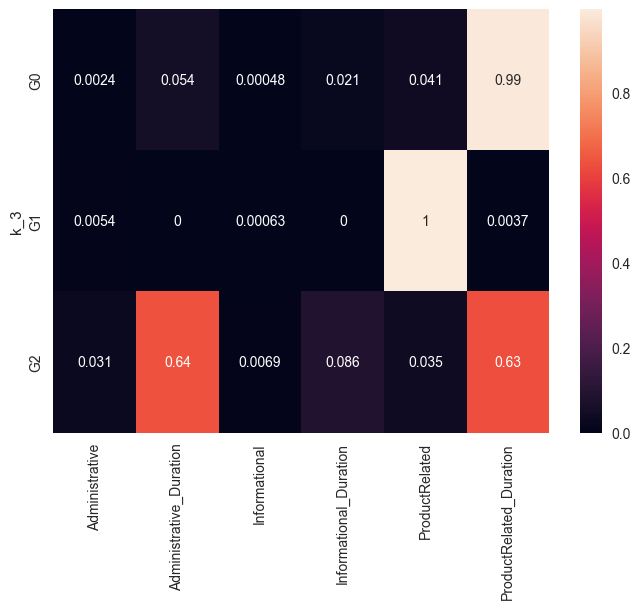

In [101]:
graph_cluster(df_group_pad, 3)

,k_4,N
0,G0,254
1,G1,10437
2,G2,708
3,G3,931


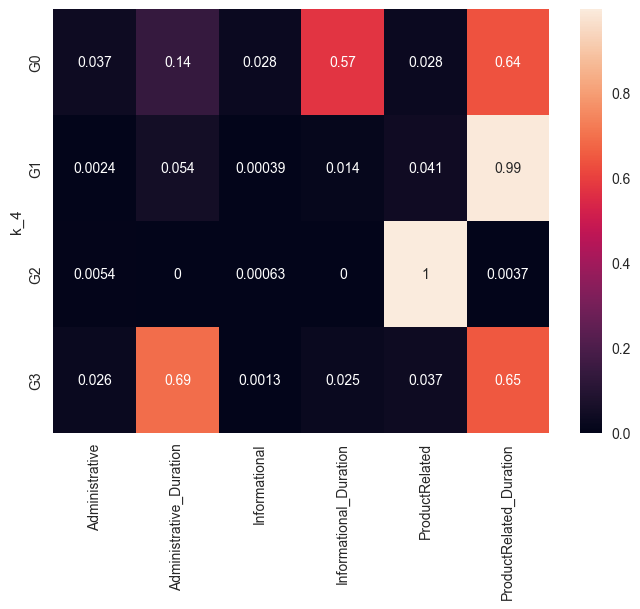

In [100]:
graph_cluster(df_group_pad, 4)

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [105]:
df_final = pd.concat([df, df_group_pad['k_3']], axis=1)
df_final.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,k_3
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,G1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,G0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,G1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,G0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,G0


In [115]:
df_final[['BounceRates','Revenue', 'k_3']].groupby('k_3').mean()

,BounceRates,Revenue
k_3,,
G0,0.011645,0.166130
G1,0.194872,0.004237
G2,0.011937,0.141917


<div style="background: #EEEEF4; padding: 15px 20px; border-radius: 5px; margin-top: 20px">
    <p style="font-size: 11px; color: #666; font-weight: bold">Resposta</p>
    <p>O G1 é o que mais acessa a página de produtos porém é o que menos compra. Já os grupos G2 e G0 são aqueles que ficam mais tempo na página e os que mais convertem.</p>
</div>